### Installation of required components

In [1]:
# %pip install spacy
# !python -m spacy download pl_core_news_sm

In [16]:
import pandas as pd
import numpy as np
import spacy
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

### Loading data and displaying examples

In [3]:
data_mail = pd.read_csv('emails_invalid.csv')
data_mail = data_mail.dropna()

data_mail['category'] = data_mail['category'].astype('category')
data_mail['subject'] = data_mail['subject'].astype(str)
data_mail['message'] = data_mail['message'].astype(str)

display(data_mail.tail(3), data_mail.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797 entries, 0 to 799
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   category  797 non-null    category
 1   message   797 non-null    object  
 2   subject   797 non-null    object  
dtypes: category(1), object(2)
memory usage: 19.8+ KB


,category,message,subject
797,WSPOLPRACA_ZE_SKLEPEM,Czy są Państwo zainteresowani odebrać oferte n...,Sprawny marketing
798,FAKTURY,Zapomniałem zaznaczyć opcje faktury czy możeci...,Faktura
799,INFORMACJE_O_ZAMOWIENIU,Mam pytanie co z naszym zamówieniem. Czy towar...,Pytanie o zamówienie


None

In [4]:
# Polish pipeline optimized for CPU.
nlp = spacy.load("pl_core_news_sm")

def clean_lemma(s):
    # Stop list - Exclusion of words with little meaning, i.e. “the”, “is” and “and”.
    # Lemmatization - means reducing a group of words that are variations of a given phrase to a common form (e.g. runs, running, ran -> run).
    doc = nlp(s)
    words = []
    for token in doc:
        if token.is_alpha and not token.is_stop:
            words.append(token.lemma_)
    return " ".join(words)

### Stop list and lemantization on data

In [5]:
X = data_mail["subject"].apply(clean_lemma) + " " + data_mail["message"].apply(clean_lemma)
y = data_mail["category"]

### Division of data into training (75%) and testing (25%)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### TF-IDF

In [7]:
# TF-IDF is a measure of originality of a word by comparing
# the number of times a word appears in a doc with the number
# of does the word appears in.
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
features = vectorizer.get_feature_names_out()

### Training & Testing

In [8]:
clf = MultinomialNB().fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [21]:
print("Accuracy: "+str(accuracy_score(y_test, y_pred)*100)+"%")

Accuracy: 100.0%


### Compute confusion matrix

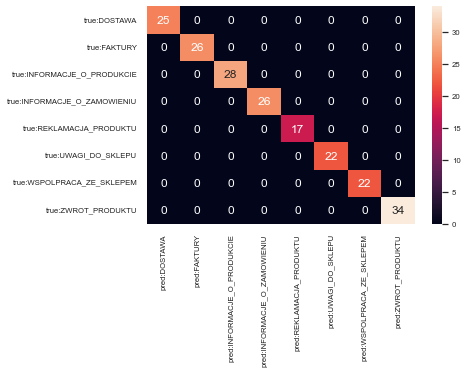

In [22]:
unique_label = np.unique([y_test, y_pred])
df_cm = pd.DataFrame(
    confusion_matrix(y_test, y_pred, labels=unique_label),
    index=["true:{:}".format(x) for x in unique_label],
    columns=["pred:{:}".format(x) for x in unique_label],
)
# Display HeatMap
sn.set(font_scale=0.7)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 12})
plt.show()

### Predicting the category of a new message

In [53]:
new_email = clean_lemma('Można prosić fakture do zamówienia?')
X_new_email = vectorizer.transform([new_email])
y_pred_new_email = clf.predict(X_new_email)
y_probs = clf.predict_proba(X_new_email)

print("MESSAGE CONTENT:\n"+new_email)
result = pd.DataFrame([y_probs[0,:]],columns=unique_label[:],index=['Matching'])
display(result)
print("E-mail category: ",y_pred_new_email)

MESSAGE CONTENT:
prosić fakture zamówienie


,DOSTAWA,FAKTURY,INFORMACJE_O_PRODUKCIE,INFORMACJE_O_ZAMOWIENIU,REKLAMACJA_PRODUKTU,UWAGI_DO_SKLEPU,WSPOLPRACA_ZE_SKLEPEM,ZWROT_PRODUKTU
Matching,0.049267,0.408879,0.041358,0.259149,0.032346,0.038002,0.037658,0.133341


E-mail category:  ['FAKTURY']
